# How to color your Map: The Good, the Bad and the Ugly
**An example using TUWien Surface Soil Moisture developed for GHG-Kit**

![](https://upload.wikimedia.org/wikipedia/en/4/45/Good_the_bad_and_the_ugly_poster.jpg)

*Image from [wikipedia](https://upload.wikimedia.org/wikipedia/en/4/45/Good_the_bad_and_the_ugly_poster.jpg)*.

In [1]:
%matplotlib widget

import xarray as xr

from pathlib import Path
from tuw_education_notebooks.view_monthly_ssm import view_monthly_ssm, load_cmap

RESOURCES = Path("data")

## Science and Art

Data visualization depends on art to convey stories from data through the combination of geometric objects and color with science. In the ideal case the information should be easily extractable from the visualization, but at the same time the scientific elements should be to the point accurate. The latter is important as false graphical representations can lead to wrong perception amd interpretation, which, in turn, leads to wrongful decision making. These mistakes can be made intentionally, and thus be fraudulent, but are more often innocent mistakes with potential far reaching consequences. When plotting data on maps we have to consider even more aspects, like the geographic projection and grid types.

## TUWien Surface Soil Moisture developed for GHG-Kit

For the examples in this notebook we will use soil moisture developed for GhG-Kit. We will provide a short explanation of how this data is derived. To retrieve surface soil moisture data we exploit the general linear relationship between Sentinel-1 microwave backscattering and soil moisture. The change detection method developed at TU Wien can be summarised in the most simple terms by calculating the driest and wettest condition within a time period and then relating the observed backscatter to retrieve the relative soil moisture or “wetness” in percent as shown in Figure 1.

![](assets/images/ssm_retrieval_change_detection.png)

*Figure 1: Change detection method for retrieving surface soil moisture.*

For the examples we show a subset of data over Austria. In Austria, two prominent challenges for soil moisture occur, these include:

- Pronounced geometric effects from varying viewing angles due to the variable topography in and around the Alps.
- Strong vegetation cover over dense forests.

In the Soil Moisture Product developed for GHG-Kit we address these challenges, using **radio metric terrain-corrected backscatter** data to “flatten” the terrain and static spatial filtering of **dense vegetation** at high resolution.

Below we load a subset with `xarray` of the soils moisture dataset, which is stored as a Zarr archive.

In [2]:
SSM_dc = xr.open_zarr(RESOURCES / "SSM-CD-SIG40-R-DVEG_2018.zarr/")
SSM_dc

<xarray.Dataset> Size: 8GB
Dimensions:      (time: 723, y: 1200, x: 1200)
Coordinates:
  * time         (time) datetime64[ns] 6kB 2018-01-01T05:08:47 ... 2018-12-31...
  * x            (x) float64 10kB 4.8e+06 4.801e+06 ... 5.399e+06 5.4e+06
  * y            (y) float64 10kB 1.8e+06 1.799e+06 ... 1.201e+06 1.2e+06
Data variables:
    band_data    (time, y, x) float64 8GB dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    spatial_ref  int64 8B ...

We resample this dataset along the time dimension thereby aggregating surface soil moisture as mean values over months.

In [3]:
SSM_dc_monthly = SSM_dc.resample(time="M").mean()
SSM_dc_monthly

/home/mschobbe/miniconda3/envs/tuw_education_notebooks/lib/python3.10/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


<xarray.Dataset> Size: 138MB
Dimensions:      (time: 12, y: 1200, x: 1200)
Coordinates:
  * x            (x) float64 10kB 4.8e+06 4.801e+06 ... 5.399e+06 5.4e+06
  * y            (y) float64 10kB 1.8e+06 1.799e+06 ... 1.201e+06 1.2e+06
  * time         (time) datetime64[ns] 96B 2018-01-31 2018-02-28 ... 2018-12-31
Data variables:
    band_data    (time, y, x) float64 138MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    spatial_ref  (time) int64 96B 0 0 0 0 0 0 0 0 0 0 0 0


Now we are ready to plot the soil moisture data on a map. To plot one variable like soil moisture on the x (longitude) and y (latitude) dimension requires finding a good representation in a 3D colorspace. This is also referred to as pseudo coloring: a method for revealing aspects of the data over a continuous plane. Foreffective pseudocoloring we need to find the correct colormap.  We can asks our selves the following questions:

- What do we know about the data. Is there e.g. a critical value to which compare the data?
- Is there a intuitive color scheme that nicely translates to the variable including the distribution of the sample.

We can choose fro,
- Sequential: equal stesps as euqal steps in color space = uniform colormaps
- Diverging: for when we have a ctirical middle value to whihc to compare data
- Cyclic: changes in ligthness and two color that meet in th middle
- qualitative: for unordered categorical data.

## The Bad

In the following maps we can see what can go wrong when don't take thse things into conisderation. What went wrong in these maps?



/home/mschobbe/miniconda3/envs/tuw_education_notebooks/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


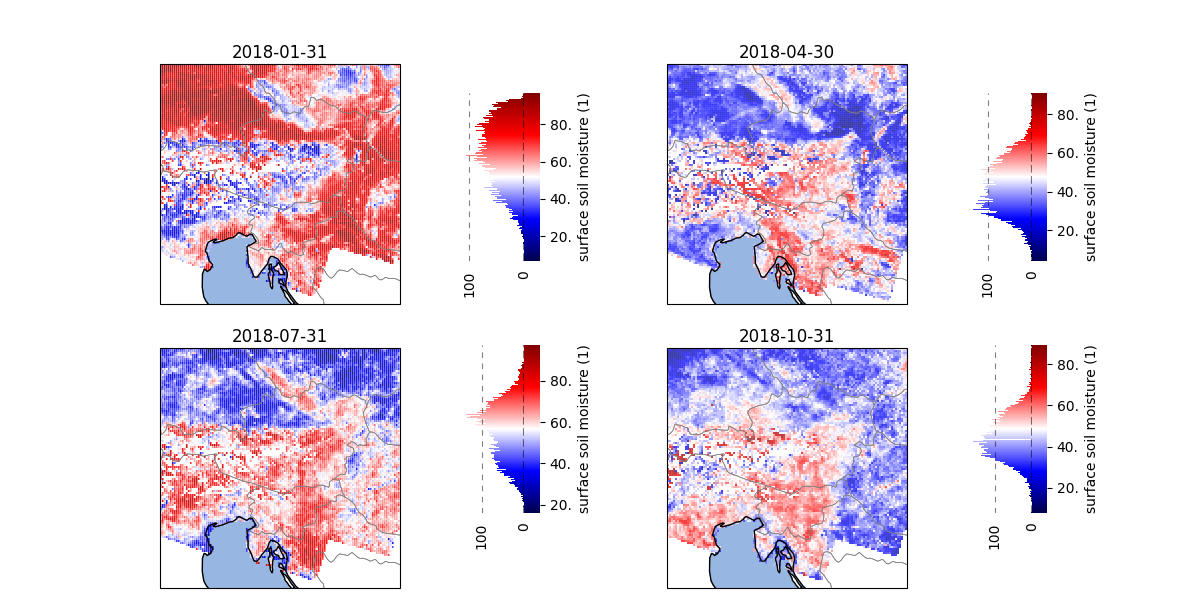

In [4]:
view_monthly_ssm(SSM_dc_monthly, "seismic")

The first mistake is thatw e took a diverging colormap although the data does not have a critical middle value. The sharp contrast bweteen the blue an red further make it almost appear if the data is binairy, as in relatt we have uniformly spaced values around a sample distribution that approximates a normal distrubition (as can be seen form the histrograms.) On top of that we have picked a colormap which include white. There is also information in what we don't see on the map: e.g. missing data points. But this colorscale can give the false impression of missing data.

## The Ugly

Let's fix the first problem. We do this by choosing the sequential "viridis" colormap. In this colorscale the lightness which is a linear function of the variable with a wide perceptual range (e.g. it is colorful). Viridis is, furthermore, colorblindness friendly and prints well in grayscale preserving perceptual uniformity and breadth of the range.


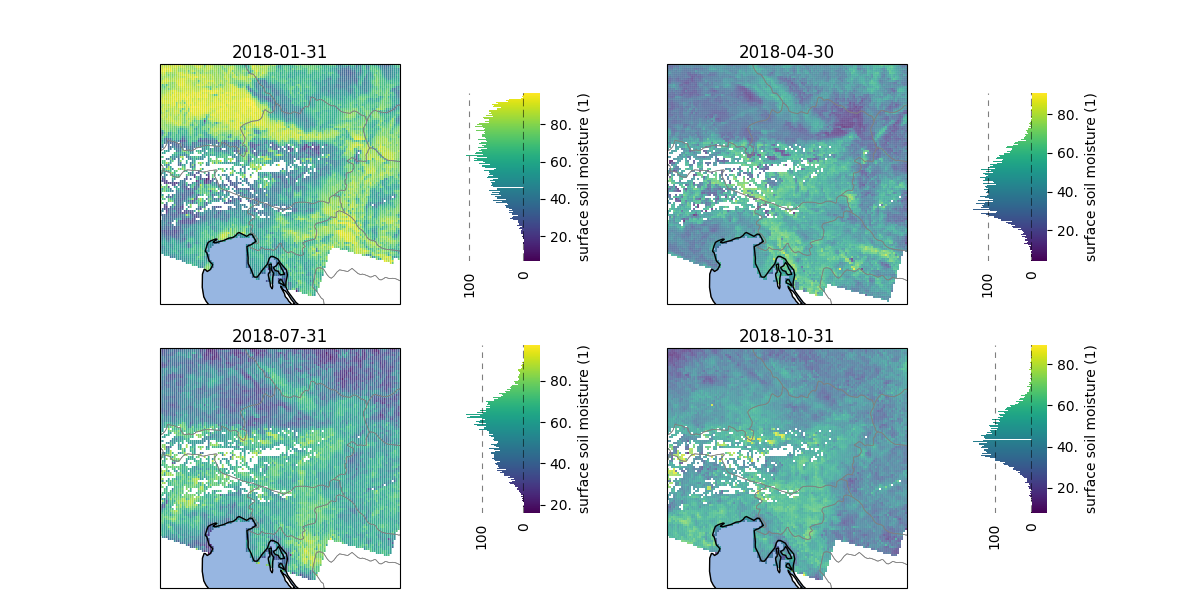

In [5]:
view_monthly_ssm(SSM_dc_monthly, "viridis")

This colormap fixes many of the previous issues. We see much more nuance in variance of soil moisture. Foremost we see also that we have actual missing data points. There is a whole area in the Alps that is not well covered. This is actually a well know effect of the measurement technique. In contrast to our previous statement, we cannot addresss all geometric effects radiometric terrain correction in microwave remote sesning. In very steep regions like the Alps, we still have to mask the data due to shadowing and layover effects. Shadowing occurs when the terrain is so steep that it blocks the view of subsequent points, preventing any measurements and obstructing scene reconstruction (See supplementary figure 1). 

## The Good

This last step is more subjective and relates to the psychology of colors: the multiple meanings and feelings that people associated with a color. Here we use a linear color gradient developed by TU Wien from brown for dry soils to blue for wet soils.

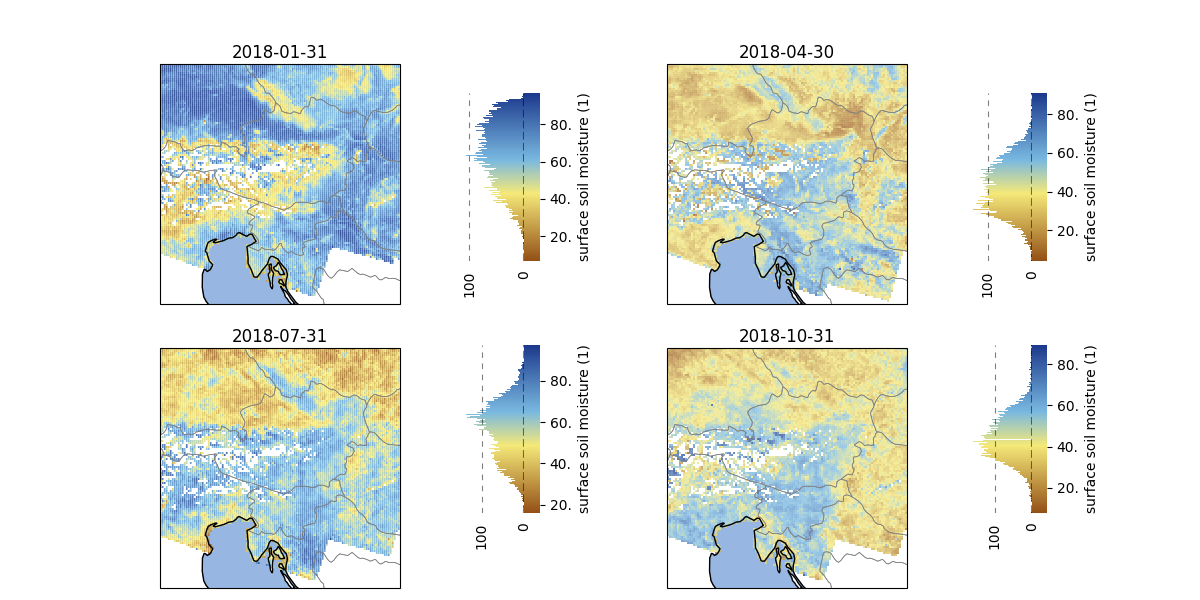

In [6]:
SSM_CMAP = load_cmap(RESOURCES / "colour-tables/ssm-continuous.ct")
view_monthly_ssm(SSM_dc_monthly, SSM_CMAP)

In this last rendition of the maps we a nice linear relation between color and soil moisture. Where the brown colors evokes images of dried out soils and blues of water saturated conditions.

## Supplement

## References